---
title: "重新認識pytorch(3)"
subtitle: "LSTM簡介與實作"
format: html
author: "紙魚"
date: "2025-08-28"
categories: [note,python,pytorch]
# format:
#   html:
#     code-fold: true
jupyter: new_env
image: "image.png"
---

 LSTM（Long Short-Term Memory）模型是 RNN 的延伸，主要目的在於改善 RNN 梯度爆炸以及長期依賴的問題。

具體來說，一般結構簡單的 RNN 使用的激勵函數為 Sigomid、tah，在沒有記憶性質的 NN 裡最多也只能疊6層 layers，否則在反向傳遞誤差時，**誤差會隨著層數增加而減少，無法有效更新權重**，有記憶性質的 RNN 在反向傳遞的誤差還會受到序列(例如從 $t+1$ 到 $t$)的影響，因此 **一般 RNN 無法學習太長的 series data**。

要改善 RNN 的問題，一般會朝兩個方向改進：使用更複雜的模型結構，或是與其他模型結合組成混合式深度學習。

LSTM 就是採前者的作法，使得他可以學習長期 series data，代價是，他的結構複雜，執行速度也拖慢很多。~~一個 ep~~

 
> 主要內容引用自 「李金洪. 2022. 全格局使用 PyTorch - 深度學習和圖神經網路 - 基礎篇. 深智數位」第 7.5 節。

# LSTM 的模型結構

懶得畫，直接找別人ㄉ

![ ](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/LSTM_cellstate.png)

[來源](https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M3_LSTM_Tutorial_v3.ipynb#scrollTo=8RuUMQ3WezoZ)


與一般 RNN 相比， LSTM 主要增加了 3 個東西

1. 遺忘門
2. 輸入門
3. 輸出門

## 遺忘門

遺忘門的作用是決定甚麼時候需要把以前的狀態忘記。LSTM 的遺忘門主要由三部分組成：

- 輸入（$x_t$）：當前時刻的輸入。

- 隱藏狀態（$h_t$ − $h_{t−1}$）：前一時間步的隱藏狀態。

- 遺忘門的激勵函數：決定了多少先前的記憶被丟棄。

所以寫成數學式為：

$f_t = \sigma ( W_f \cdot [h_{t-1}, x_t] + b_f )$

其中：

- $f_t$：遺忘門的輸出結果

- $\sigma$：激勵函數

- $b_f$：遺忘門的 bais

## 輸入門

輸入門有兩個功能，一個是找到需要更新的細胞狀態，另一個是把需要更新的資訊更新到細胞狀態裡。具體而言數學式為：

- $i_t = \sigma (W_i \cdot [h_{t-1},x_t] + b_i)$

- $\hat C_t = \tanh (W_C \cdot [h_{t-1},x_t] + b_C)$

其中：

- $i_t$︰要更新的細胞狀態

- $h_{t-1}$︰前一個時間點的模型輸出

- $W_i$：計算 $i_t$ 的權重

- $W_C$：計算 $\hat C_t$ 的權重

- $b_i$：計算 $\hat C_t$

當遺忘門找到需要忘記的資訊$f_t$時，會將其與舊的狀態相乘，然後再與輸入門產生的 $i_t \times \hat C_{t-1}$相加，使細胞獲得新的資訊，完成細胞狀態的更新，數學式為：

$C_t = f_t \times C_{t-1} + i_t \times \hat C_t$

## 輸出門

輸出門會透過一個啟動函數層來確定哪部份的資訊要被輸出，接著決定模型在特定時間點 $t$ 的數學結果，具體數學式如下：

- $o_t = \sigma (W_o \cdot [h_{t-1},x_t] + b_o)$

- $h_t = o_t \times (C_t)$

# 實作：退位減法

為了跟前面的手刻 RNN 比較，再拿退位減法當例子~~雖然很大才小用~~。再複述一次退位減法的語法結構：

$$a - b = c$$

其中 a、b、c都是整數，且$a>b$，**我們的目標是a、b已知的前提下，印出來的c要是正確的**，先來生成資料(a、b、c)。

資料生成大致與上次相同，不同的是多了將資料轉成可供 pytorch 的 `DataLoader` 格式，並且區分訓練集跟驗證集：

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
# 設定隨機種子以保證可重現性
SEED = 822
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

def requires_borrow(a, b):
    """檢查 a - b 是否會需要退位（borrow）"""
    a_str = str(a)[::-1]  # 反轉為從低位開始
    b_str = str(b)[::-1]

    for i in range(len(b_str)):
        a_digit = int(a_str[i]) if i < len(a_str) else 0
        b_digit = int(b_str[i])
        if a_digit < b_digit:
            return True
    return False


largest_number = 255
binary_dim = 8  # 每個數字最多 8 bits

int2binary = {}
binary = np.unpackbits(
    np.array([range(2**binary_dim)], dtype=np.uint8).T, axis=1
)
for i in range(2**binary_dim):
    int2binary[i] = binary[i]

data = []
while len(data) < 10000:
    a_int = np.random.randint(2, largest_number)  # 最大為 254
    b_int = np.random.randint(1, a_int)  # b < a，且最小是 1

    if not requires_borrow(a_int, b_int):
        continue

    a = int2binary[a_int]
    b = int2binary[b_int]
    c_int = a_int - b_int
    c = int2binary[c_int]

    data.append((a, b, c))

class BinarySubtractionDataset(Dataset):
    def __init__(self, data):
        self.samples = []
        for a, b, c in data:
            x = np.array(list(zip(a[::-1], b[::-1])), dtype=np.float32)  # time_steps x input_dim
            y = c[::-1].astype(np.float32)  # 目標也反轉（低位在前）
            self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x), torch.tensor(y)

# 建立資料集
dataset = BinarySubtractionDataset(data)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)


然後來製作模型

## 模型定義

LSTM 模型的結構雖然複雜，但在 pytorch 裡的語法結構與普通的 NN 差不多。只是本次的課題要處理減法算出的數字的二進位版本，輸出會是由 0 與 1 組成的序列，比較特殊，因此模型結構也以此設計。先來看看一般 LSTM 模型的架構在pythorch中是什麼樣子，以下是一個是個通用範例：

```python
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
            out, _ = self.lstm(x)    # [batch, seq_len, hidden_size]
            out = self.fc(out)       # [batch, seq_len, output_size]
            return out
```

可以看到與之前看到的 NN 模型類似，都需要用一個 class 包覆，也需要設定 input、output、hidden數，以及正向傳遞。

由於本次課題的特殊性，本次使用的模型多了一個 `self.sigmoid = nn.Sigmoid()`，這是為了跟後續 loss function 的設定 `BCELoss()`配合。模型設定如下：


In [2]:
import torch.nn as nn

class LSTMSubtractor(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super(LSTMSubtractor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # output: (batch, seq_len, hidden)
        out = self.fc(lstm_out)     # (batch, seq_len, 1)
        return self.sigmoid(out)    # predict bit 0 or 1


### 參數設定與模型訓練

 參數設定如下：

接著來設定參數：

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMSubtractor().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 100

這裡要解釋 `nn.BCELoss()` 是什麼東西，根據 [pytorch 官方文件](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) ，它的數學式為：

for all sample size $n$

$$
\ell_n = - w_n \left[ y_n \cdot \log(x_n) + (1 - y_n) \cdot \log(1 - x_n) \right]
$$

* $x_n$：模型輸出機率（預測值），需介於 0 與 1 之間
* $y_n$：真實值（0 或 1）
* $w_n$：逐樣本權重（若未指定權重則預設為 1）

然後 $\ell_n$ 可以組成向量 $L = (l_1, \dots , l_n)^T$，接著按照裡面的設定不同，輸出也會不同：

$$\ell(x, y) =
\begin{cases}
\text{mean}(L), & \text{if reduction='mean'} \\
\text{sum}(L), & \text{if reduction='sum'}
\end{cases}$$

整批次資料的損失根據 `reduction` 的設定方式不同，被輸出為一個 scalar：

* **`'mean'`（預設）**：

  $$
  \text{loss} = \frac{1}{N} \sum_{n=1}^{N} \ell_n
  $$
* **`'sum'`**：

  $$
  \text{loss} = \sum_{n=1}^{N} \ell_n
  $$
* **`'none'`**：
  保持逐元素損失，不做處理，輸出與輸入相同


由於 $x_n = 0$ 或 $x_n = 1$ 時會導致 $\log(0)$ 出現負無限大，PyTorch 在實作中將 log 的最小值限制為 $-100$，避免出現無限大或梯度爆炸的情況，確保訓練穩定。

接著，我們將　epoch　(模型掃過資料的次數)設為 100，對訓練集訓練：


In [4]:


for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(-1)  # (batch, 8, 1)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}", end='\r')


定義預測函數、進行預測後，再來查看在測試集的效果：

In [5]:
def binary2int(binary_array):
    """將二進位 ndarray 轉換為十進位整數"""
    return int("".join(str(int(b)) for b in binary_array), 2)


def predict(model, a_int, b_int):
    model.eval()
    a = int2binary[a_int]
    b = int2binary[b_int]
    x = np.array(list(zip(a[::-1], b[::-1])), dtype=np.float32)
    x_tensor = torch.tensor(x).unsqueeze(0).to(device)  # (1, 8, 2)

    with torch.no_grad():
        pred = model(x_tensor).squeeze().cpu().numpy()

    pred_bits = np.round(pred).astype(int)[::-1]  # 反轉回原本順序
    pred_val = sum([bit * (2 ** i) for i, bit in enumerate(pred_bits[::-1])])
    return pred_val, pred_bits


## 結果

In [6]:
def bits_to_int(bit_tensor):
    """將 bit tensor 轉為十進位整數（從低位開始）"""
    bits = bit_tensor.int().numpy().tolist()
    return int("".join(str(b) for b in bits[::-1]), 2)  # 注意反轉



Error_list = []

for j in range(len(test_set)):
    # 讀一筆
    x, y = test_set[j]

    # 拆開 a 和 b 的 bits（注意 shape 是 [seq_len, 2]）
    a_bits = x[:, 0]
    b_bits = x[:, 1]
    c_bits = y
    

    # 還原整數
    a_int = bits_to_int(a_bits)
    b_int = bits_to_int(b_bits)
    c_int = bits_to_int(c_bits)  
    d = predict(model, a_int, b_int)
    
    # 紀錄誤差
    error = np.abs(c_int - d[0]) 
    Error_list.append(error)     
    # 取其中的五筆觀察
    if j % 200 == 0: 
        # 顯示
        print(f"True value:　{c_int} ; {c}")
        print(f"Predicted value: {d[0]} ; {d[1]}")
        print(f"Predicted formula: {a_int} - {b_int} = {d[0]}")
        print("---------------")


True value:　62 ; [0 0 0 0 1 1 1 1]
Predicted value: 62 ; [0 0 1 1 1 1 1 0]
Predicted formula: 123 - 61 = 62
---------------
True value:　24 ; [0 0 0 0 1 1 1 1]
Predicted value: 24 ; [0 0 0 1 1 0 0 0]
Predicted formula: 118 - 94 = 24
---------------
True value:　116 ; [0 0 0 0 1 1 1 1]
Predicted value: 116 ; [0 1 1 1 0 1 0 0]
Predicted formula: 250 - 134 = 116
---------------
True value:　137 ; [0 0 0 0 1 1 1 1]
Predicted value: 137 ; [1 0 0 0 1 0 0 1]
Predicted formula: 204 - 67 = 137
---------------
True value:　185 ; [0 0 0 0 1 1 1 1]
Predicted value: 185 ; [1 0 1 1 1 0 0 1]
Predicted formula: 245 - 60 = 185
---------------


把誤差化成圖：

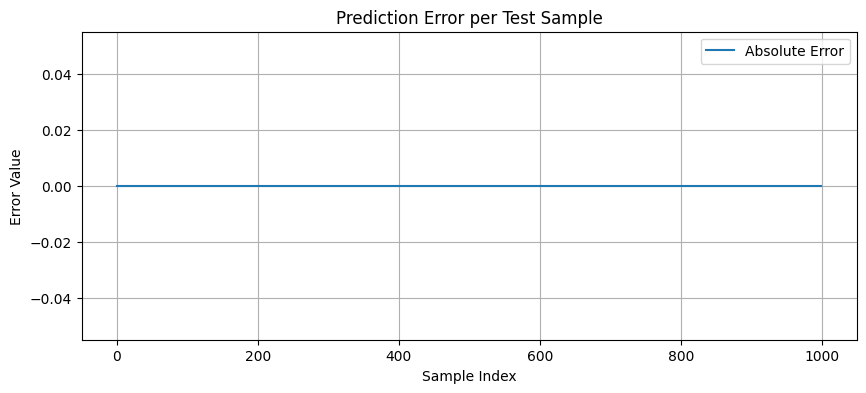

In [7]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 4))
plt.plot( Error_list, label="Absolute Error")
plt.xlabel("Sample Index")
plt.ylabel("Error Value")
plt.title("Prediction Error per Test Sample")
plt.grid(True)
plt.legend()
plt.show()


在測試集的表現非常好，順便來介紹 & 計算常用模型評估指標，RMSE。RMSE（Root Mean Squared Error）為 MSE 的平方根，是常用的模型誤差評估指標。

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2 } = \sqrt{\text{MSE}}
$$


In [8]:
import numpy as np

true_vals = []
pred_vals = []

for x, y in test_set:
    # 還原 a、b 的 bit 並轉為十進位
    a_int = bits_to_int(x[:, 0])
    b_int = bits_to_int(x[:, 1])
    true_val = bits_to_int(y)

    pred_val, _ = predict(model, a_int, b_int)

    true_vals.append(true_val)
    pred_vals.append(pred_val)

# 轉為 numpy 陣列
true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = np.abs(true_vals - pred_vals)
# 計算 RMSE
rmse = np.sqrt(np.mean((true_vals - pred_vals) ** 2))
print(f"RMSE: {rmse:.4f}")


RMSE: 0.0000


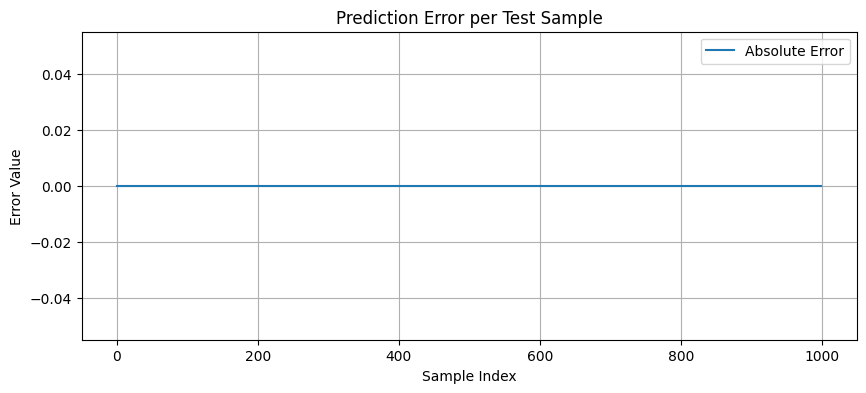

In [9]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 4))
x = [ x for x in range(501, 1001)]
plt.plot( errors, label="Absolute Error")
plt.xlabel("Sample Index")
plt.ylabel("Error Value")
plt.title("Prediction Error per Test Sample")
plt.grid(True)
plt.legend()
plt.show()


這裡因為誤差是 0 RMSE 想當然爾也是0囉。

# 補充：GRU 模型

GRU 模型與 LSTM 功能幾乎一樣，差異在**GRU將遺忘門和輸入門簡化為單一一個門，同時將細胞狀態和隱藏狀態結合為一個狀態**，大幅簡化原先 LSTM 模型的設計。 

## GRU 延伸閱讀

- [LSTM與GRU比較論文摘要](https://tengyuanchang.medium.com/%E6%AF%94%E8%BC%83%E9%95%B7%E7%9F%AD%E6%9C%9F%E8%A8%98%E6%86%B6%E6%A8%A1%E5%9E%8B-lstm-%E8%88%87%E6%94%B9%E8%89%AF%E5%BE%8C%E7%9A%84%E9%81%9E%E6%AD%B8%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF%E6%A8%A1%E5%9E%8B-gru-813dec22ec6d)
